In [ ]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

In [ ]:
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)
latent_dim = 10
batch_size = 16
epsilon_std = 1.0

In [ ]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [ ]:
def build_encoder():
    img = Input(shape=img_shape)
    h = Flatten()(img)
    h = Dense(512)(h)
    h = LeakyReLU(alpha=0.2)(h)
    h = Dense(512)(h)
    h = LeakyReLU(alpha=0.2)(h)
    mu = Dense(latent_dim)(h)
    log_var = Dense(latent_dim)(h)
    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([mu, log_var])
    return Model(img, z)

In [ ]:
def build_decoder():
    model = Sequential()
    model.add(Dense(512, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    # tanh is more robust: gradient not equal to 0 around 0
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))
    model.summary()
    z = Input(shape=(latent_dim,))
    img = model(z)
    return Model(z, img)

In [ ]:
def build_discriminator():
    model = Sequential()
    model.add(Dense(512, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation="sigmoid"))
    model.summary()
    encoded_repr = Input(shape=(latent_dim,))
    validity = model(encoded_repr)
    return Model(encoded_repr, validity)

In [ ]:
optimizer = Adam(0.0002, 0.5)

# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])

# Build the encoder / decoder
encoder = build_encoder()
decoder = build_decoder()

img = Input(shape=img_shape)
# The generator takes the image, encodes it and reconstructs it
# from the encoding
encoded_repr = encoder(img)
reconstructed_img = decoder(encoded_repr)

# For the adversarial_autoencoder model we will only train the generator
# if discriminator is attached to generator, set this flag to fix discriminator
discriminator.trainable = False

# The discriminator determines validity of the encoding
validity = discriminator(encoded_repr)

# The adversarial_autoencoder model  (stacked generator and discriminator)
adversarial_autoencoder = Model(img, [reconstructed_img, validity])
adversarial_autoencoder.compile(loss=['mse', 'binary_crossentropy'], loss_weights=[0.999, 0.001], optimizer=optimizer)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               5632      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 137,217
Trainable params: 137,217
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
____________________________

In [ ]:
def train(epochs, batch_size=128, sample_interval=50):
    # Load the dataset
    (X_train, _), (_, _) = mnist.load_data()

    # Rescale -1 to 1
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_train = np.expand_dims(X_train, axis=3)
    print(X_train.shape[0])
    # Adversarial ground truths
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        #  Train Discriminator

        # Select a random batch of images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        latent_fake = encoder.predict(imgs)
        latent_real = np.random.normal(size=(batch_size, latent_dim))

        # Train the discriminator
        # let latent_real's output is close to 1
        d_loss_real = discriminator.train_on_batch(latent_real, valid)
        # let latent_fake's output is close to 0
        d_loss_fake = discriminator.train_on_batch(latent_fake, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train the generator
        # decrease reconstruction error and let discriminator's output is close to 1
        g_loss = adversarial_autoencoder.train_on_batch(imgs, [imgs, valid])

        # If at save interval
        if epoch % sample_interval == 0:
            # Plot the progress
            #print("%d [D loss: %f, acc: %.2f%%] [G loss: %f, mse: %f]" % (
                #epoch, d_loss[0], 100 * d_loss[1], g_loss[0], g_loss[1]))
            # save generated image samples
            sample_images(epoch)

In [ ]:
# Save generated images per specified epochs 
def sample_images(epoch):
    r, c = 5, 5
    z = np.random.normal(size=(r * c, latent_dim))
    gen_imgs = decoder.predict(z)
    gen_imgs = 0.5 * gen_imgs + 0.5
    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    fig.savefig("mnist_%d.png" % epoch)
    plt.close()

In [ ]:
epochs = 4000
sample_interval = 200
sample_count = epochs/sample_interval

In [ ]:
train(epochs=epochs, batch_size=batch_size, sample_interval=sample_interval)

60000


In [ ]:
lacc = X_train.history['accuracy']
val_acc = X_train.history['val_accuracy']
loss = X_train.history['loss']
val_loss = X_train.history['val_loss']

epochs_range = range(2000)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, lacc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Courbe d apprentissage et accurence ')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Courbe d apprentissage et perte')
plt.show()

NameError: ignored

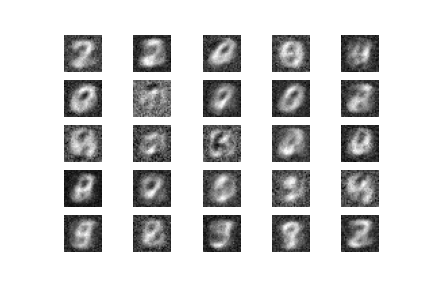

In [ ]:
Image.open('mnist_200.png')

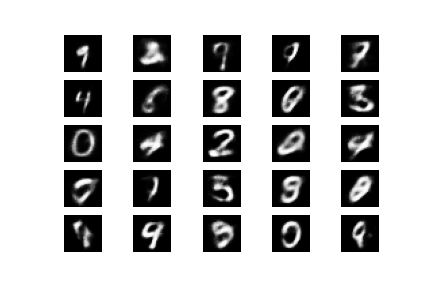

In [ ]:
Image.open('mnist_2800.png')

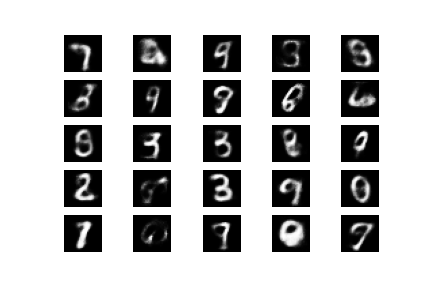

In [ ]:
Image.open('mnist_3800.png')

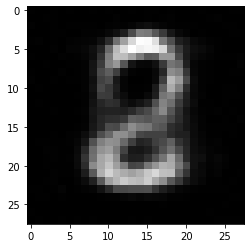

In [ ]:
z = np.random.normal(size=(1, latent_dim))
gen_imgs = decoder.predict(z)
gen_imgs = 0.5 * gen_imgs + 0.5
plt.imshow(gen_imgs[0, :, :, 0], cmap='gray')

In [ ]:
if e == 1 or e % 20 == 0:
    plot_generated_images(e, generator)